## Import libraries

In [1]:
# Tensorflow are only used to load and normalize data
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Load and Preprocess data

,image,label
0,,1 (bean_rust)
1,,1 (bean_rust)
2,,1 (bean_rust)
3,,0 (angular_leaf_spot)
4,,0 (angular_leaf_spot)

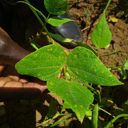
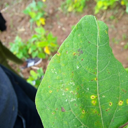
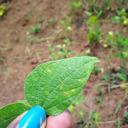
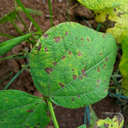
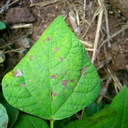

In [2]:
# Load beans data set
(ds_train, ds_test), info = tfds.load('beans', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info = True)
tfds.as_dataframe(ds_train.take(5), info)

In [3]:
# function to normalize image and apply it to train and test data set
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [4]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [5]:
# since initial image's shape is (500, 500, 3), which is so large and make the model run slowly, we'll use openCV, specifically
# cv2 to transform it to (64, 64, 3)
import cv2
# for train set
X_train_org = []
y_train_org = []
for image, label in tfds.as_numpy(ds_train):
    resizeImage = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    X_train_org.append(resizeImage)
    y_train_org.append(label)
X_train_org = np.array(X_train_org)
y_train_org = np.array(y_train_org)

# for test set
X_test_org = []
y_test_org = []
for image, label in tfds.as_numpy(ds_test):
    resizeImage = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    X_test_org.append(resizeImage)
    y_test_org.append(label)
X_test_org = np.array(X_test_org)
y_test_org = np.array(y_test_org)


In [10]:
# reshape to (12288, number of data)
X_train = X_train_org.reshape(X_train_org.shape[0], -1).T
X_test = X_test_org.reshape(X_test_org.shape[0], -1).T

In [11]:
# one hot encoding y_train and y_test
classNum = 3
m_train = X_train.shape[1]
m_test = X_test.shape[1]
# for train set
y_train = np.zeros((m_train,classNum))
for i in range(m_train):
    y_train[i][y_train_org[i]] = 1
y_train = y_train.T

# for test set
y_test = np.zeros((m_test,classNum))
for i in range(m_test):
    y_test[i][y_test_org[i]] = 1
y_test = y_test.T

## Create functions to train model

In [12]:
# create layers and its size
layers_dims = [12288, 1000, 100, 10, 3] # 5 layers
L = 5

In [13]:
def initialize_parameters(layers_dims):
    parameters = {}
    # He et al. initialization
    for i in range(1, L):
        parameters['W' + str(i)] = np.random.randn(layers_dims[i], layers_dims[i-1])*np.sqrt(2 / layers_dims[i-1])
        parameters['b' + str(i)] = np.zeros((layers_dims[i],1))
    return parameters

In [15]:
# activation functions for forward and backward propagation
def relu(Z):
    return np.maximum(Z, 0)
def softmax(Z):
    E = np.exp(Z)
    return E / (np.sum(E, axis = 0, keepdims = True))
def relu_derivative(Z):
    return (Z > 0).astype(float)

In [16]:
def one_layer_forward(A_prev, W, b, activation):
    # linear forward
    Z = np.dot(W, A_prev) + b
    cache = [Z, A_prev, W, b]
    if activation == "relu":
        A = relu(Z)
        cache.append("relu")
    elif activation == "softmax":
        A = softmax(Z)
        cache.append("softmax")
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    return A, cache

def L_layers_forward(X, parameters, L):
    # caches to save data at each layer like Z, W, b for backward propagation
    caches = []
    A_prev = X
    for i in range(1, L-1):
        A, cache = one_layer_forward(A_prev, parameters['W' + str(i)], parameters['b' + str(i)], activation = 'relu')
        caches.append(cache)
        A_prev = A
    AL, cache = one_layer_forward(A_prev, parameters['W' + str(L-1)], parameters['b' + str(L-1)], activation = 'softmax')
    caches.append(cache)
    assert(AL.shape == (3,X.shape[1]))
            
    return AL, caches
    

In [17]:
def compute_cost(AL, y):
    assert(AL.shape == y.shape)
    cost = -np.mean(y * np.log(AL))
    return cost

In [18]:
def L_layers_backward(AL, y, caches):
    assert(AL.shape == y.shape)
    m = y.shape[1]
    
    # last layer backward propagation
    dAL = AL - y
    dW = [0] * L
    db = [0] * L
    Z_last, A_prev_last, W_last, b_last, _ = caches[L-2]
    dW[L-1] = (1/m) *np.dot(dAL, A_prev_last.T)
    db[L-1] = (1/m)  *np.sum(dAL, axis = 1, keepdims = True)
    
    # remaining layers backward propagation
    dZ_next = dAL
    for i in range(L-2, 0, -1):
        Z_i_next, A_i, W_i_next, b_i_next, _ = caches[i]
        Z_i, A_i_prev, W_i, b_i, _ = caches[i-1]
        dZ_i = np.dot(W_i_next.T, dZ_next) * relu_derivative(Z_i)
        dW[i] = (1/m) * np.dot(dZ_i, A_i_prev.T)
        db[i] = (1/m) * np.sum(dZ_i, axis = 1, keepdims = True)
        dZ_next = dZ_i
    return dW, db

In [19]:
def update_parameters(parameters, dW, db, alpha):
    for i in range(1, L):
        parameters["W" + str(i)] = parameters["W" + str(i)] - alpha * dW[i]
        parameters["b" + str(i)] = parameters["b" + str(i)] - alpha * db[i]
    return parameters

In [21]:
import matplotlib.pyplot as plt
def train_model(X, y, initial_paramerters, layers_dims, alpha = 0.0075, num_iterations = 3000, print_cost = False):
    costs = []
    parameters = initial_paramerters
    for i in range (0, num_iterations):
        AL, caches = L_layers_forward(X, parameters, L)
        cost = compute_cost(AL, y)
        dW, db = L_layers_backward(AL, y, caches)
        parameters = update_parameters(parameters, dW, db, alpha)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(alpha))
    plt.show()
    return parameters

Cost after iteration 0: 0.376382
Cost after iteration 100: 0.286784
Cost after iteration 200: 0.261007
Cost after iteration 300: 0.238804
Cost after iteration 400: 0.200940
Cost after iteration 500: 0.191898
Cost after iteration 600: 0.267123
Cost after iteration 700: 0.196885
Cost after iteration 800: 0.169170
Cost after iteration 900: 0.118313
Cost after iteration 1000: 0.090667
Cost after iteration 1100: 0.287542
Cost after iteration 1200: 0.066426
Cost after iteration 1300: 0.054777
Cost after iteration 1400: 0.052191
Cost after iteration 1500: 0.022453
Cost after iteration 1600: 0.124769
Cost after iteration 1700: 0.018791
Cost after iteration 1800: 0.013025
Cost after iteration 1900: 0.009934
Cost after iteration 2000: 0.008094
Cost after iteration 2100: 0.006772
Cost after iteration 2200: 0.005759
Cost after iteration 2300: 0.004975
Cost after iteration 2400: 0.004355


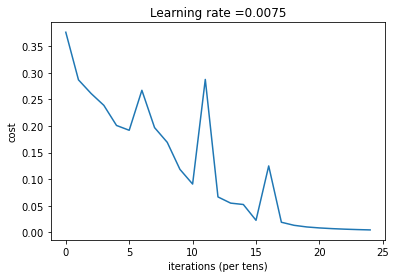

In [23]:
# train model
initial_parameters = initialize_parameters(layers_dims)
parameters = train_model(X_train, y_train, initial_parameters, layers_dims, num_iterations = 2500, print_cost = True)

In [24]:
def predict(X, y, parameters):
    AL, caches = L_layers_forward(X, parameters, L=5)
    y_hat = np.argmax(AL, axis=0)
    y = np.argmax(y, axis=0)
    accuracy = (y_hat == y).mean()
    return accuracy * 100

In [25]:
# accuracy on test set
accuracy = predict(X_test, y_test, parameters)
accuracy

83.59375

In [27]:
# accuracy on train set
accuracy = predict(X_train, y_train, parameters)
accuracy

100.0

Since we got 100% accuracy on train set, but only 83.6% on test set, we're encountering overfitting issue.
Let's implement layer dropout regularization to reduce it. (Coming soon...)